In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from collections import OrderedDict

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sb
import cv2

In [2]:
!pip install -q kaggle

#**Kaggle's Data**


Go to your Kaggle account settings, create a new token (kaggle.json), and upload this to Colab before running the cell below.

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#download and unzip the dataset
!kaggle datasets download -d mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out
!unzip -q asl-rgb-depth-fingerspelling-spelling-it-out.zip

Dataset URL: https://www.kaggle.com/datasets/mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out
License(s): unknown
100% 2.10G/2.11G [00:19<00:00, 63.6MB/s]
100% 2.11G/2.11G [00:19<00:00, 115MB/s] 


##**Create a combined dataset from each folder of the original dataset**

In [4]:
import os
import shutil

# Define the source and destination directories
source_dir = '/content/dataset5'
destination_dir = '/content/selected_dataset5'

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Set of letters we're interested in (assuming A to Z but in practice, you might only need A to X)
letters_of_interest = set(chr(i) for i in range(ord('A'), ord('X')+1))

# Iterate over each main folder (A to E)
for main_folder in ['A', 'B', 'C', 'D', 'E']:
    # Path to the main folder
    main_folder_path = os.path.join(source_dir, main_folder)

    # Iterate over each subfolder within the main folder (letters A to Z)
    for letter in os.listdir(main_folder_path):
        # Ensure we're only working with letters of interest
        if letter.upper() not in letters_of_interest:
            continue

        subfolder_path = os.path.join(main_folder_path, letter)

        # Ensure the path is a directory
        if os.path.isdir(subfolder_path):
            # List all files that start with 'color' and are of type '.png'
            images = [f for f in os.listdir(subfolder_path) if f.startswith('color') and f.endswith('.png')]

            # Sort the images to maintain consistent order
            images.sort()

            # Select the first 50 images (if there are at least 50)
            selected_images = images[:50]

            # Path to the destination subfolder for the letter (across all main folders A to E)
            dest_subfolder_path = os.path.join(destination_dir, letter.upper())  # Ensure letter is uppercase
            os.makedirs(dest_subfolder_path, exist_ok=True)

            # Copy each selected image to the destination subfolder
            for image in selected_images:
                source_image_path = os.path.join(subfolder_path, image)
                # Avoid filename conflicts by prefixing with main folder name
                destination_image_path = os.path.join(dest_subfolder_path, f"{main_folder}_{image}")
                shutil.copy2(source_image_path, destination_image_path)

print("Images have been copied.")


Images have been copied.


**Helper function**

In [5]:
def plot_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(5, 15))

<Figure size 500x1500 with 0 Axes>

<Figure size 500x1500 with 0 Axes>

#**Canny filter**

**Ploting Cany Images**

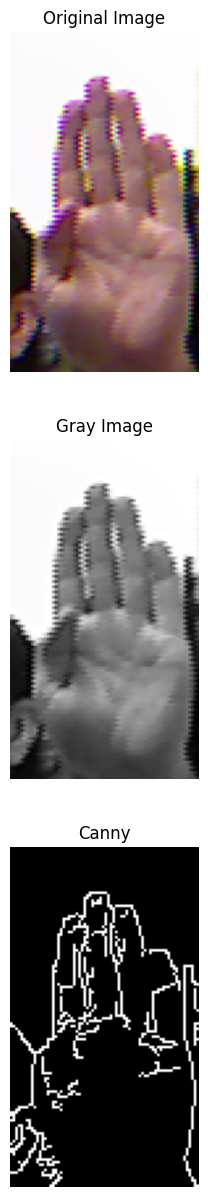

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path

img1 = cv2.imread('/content/dataset5/A/b/color_1_0011.png')
plt.subplot(3,1,1)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plot_image(img1_rgb, 'Original Image')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img1, 100, 200)

plt.subplot(3,1,2)
plot_image(img1, 'Gray Image')
plt.subplot(3,1,3)
plot_image(edges, 'Canny')

**Dataset for Canny Filter**

In [ ]:
def process_image(image_path):
 # Read the image
  image = cv2.imread(image_path)
  if image is None:
    print(f"Failed to load image at {image_path}")
    return

  # Convert to grayscale for Canny edge detection later
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Apply Canny edge detection on the grayscale image
  edges = cv2.Canny(gray_image, 100, 200)

  return edges

def create_directory(directory_path):
  if not os.path.exists(directory_path):
    os.makedirs(directory_path)

def process_dataset(input_directory, output_directory):

  # Path to the directory containing RGB images
  pathlist = Path(input_directory).rglob('*color*.png')
  print(pathlist)
  for path in pathlist:
    # Construct the path for the new directories
    new_dir = os.path.join(output_directory, path.parent.relative_to(input_directory))
    create_directory(new_dir)  # Create the directory if it does not exist

    # Process the image
    edges = process_image(str(path))

    # Save the processed images in a new directory maintaining the structure

    cv2.imwrite(f"{new_dir}/{path.stem}.png", edges) # even though edges is a binary images, cv2 will save it as rgb as its the default
    print(f"Processed and saved: {path.stem} in {new_dir}")

# Example usage
process_dataset('/content/selected_dataset5', '/content/selected_dataset_canny')


Streaming output truncated to the last 5000 lines.
Processed and saved: C_color_6_0029 in /content/selected_dataset_canny/G
Processed and saved: A_color_6_0041 in /content/selected_dataset_canny/G
Processed and saved: B_color_6_0041 in /content/selected_dataset_canny/G
Processed and saved: D_color_6_0019 in /content/selected_dataset_canny/G
Processed and saved: A_color_6_0026 in /content/selected_dataset_canny/G
Processed and saved: D_color_6_0033 in /content/selected_dataset_canny/G
Processed and saved: B_color_6_0012 in /content/selected_dataset_canny/G
Processed and saved: C_color_6_0011 in /content/selected_dataset_canny/G
Processed and saved: C_color_6_0003 in /content/selected_dataset_canny/G
Processed and saved: A_color_6_0031 in /content/selected_dataset_canny/G
Processed and saved: E_color_6_0028 in /content/selected_dataset_canny/G
Processed and saved: A_color_6_0014 in /content/selected_dataset_canny/G
Processed and saved: A_color_6_0008 in /content/selected_dataset_canny/G


#**Blurring and Contrast Enhancement Filter**

**Ploting Contrast Images**

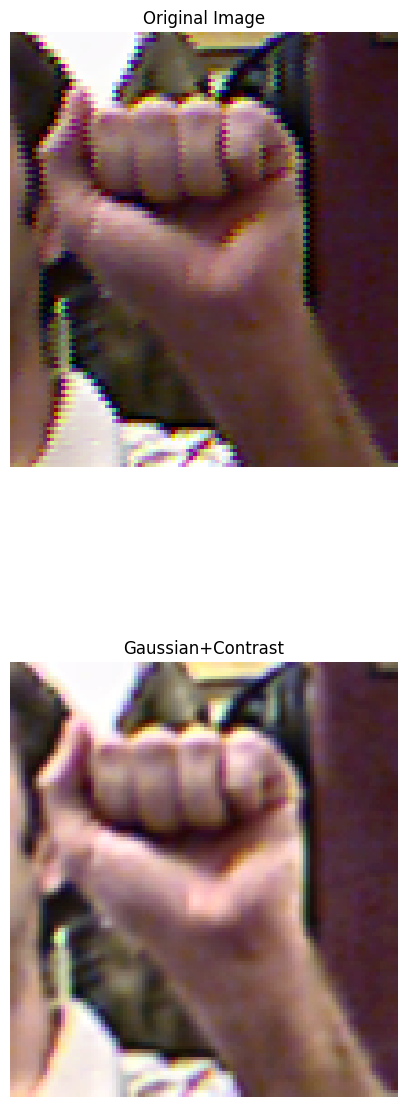

In [6]:
import numpy as np
import os
from pathlib import Path
from skimage import io, color, exposure
import random
import cv2 as cv
import matplotlib.pyplot as plt


image = cv2.imread('/content/selected_dataset5/A/A_color_0_0002.png')  # Directly read in grayscale

blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
# Convert the image to LAB color space to adjust the contrast in the L channel
lab_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2LAB)

# Split the LAB image into its channels
l_channel, a_channel, b_channel = cv2.split(lab_image)

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel
# You can adjust the clip limit and tile grid size for different contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_l_channel = clahe.apply(l_channel)

# Merge the enhanced L channel back with the A and B channels
enhanced_lab_image = cv2.merge([enhanced_l_channel, a_channel, b_channel])

# Convert back from LAB to BGR color space
enhanced_image = cv2.cvtColor(enhanced_lab_image, cv2.COLOR_LAB2BGR)
enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,15))
plt.subplot(2,1,1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_image(image, 'Original Image')
plt.subplot(2,1,2)
plot_image(enhanced_image, 'Gaussian+Contrast')

**Dataset for Contrast Enhancement**

In [7]:
def process_image(image_path):
  image = cv.imread(image_path)

  # Check if the image was loaded correctly
  if image is None:
      print("Image not found. Check the file path.")
  else:
      blurred_image = cv.GaussianBlur(image, (3, 3), 0)
      # Convert the image to LAB color space to adjust the contrast in the L channel
      lab_image = cv.cvtColor(blurred_image, cv.COLOR_BGR2LAB)

      # Split the LAB image into its channels
      l_channel, a_channel, b_channel = cv.split(lab_image)

      # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel
      # You can adjust the clip limit and tile grid size for different contrast enhancement
      clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
      enhanced_l_channel = clahe.apply(l_channel)

      # Merge the enhanced L channel back with the A and B channels
      enhanced_lab_image = cv.merge([enhanced_l_channel, a_channel, b_channel])

      # Convert back from LAB to BGR color space
      enhanced_image = cv.cvtColor(enhanced_lab_image, cv.COLOR_LAB2BGR)

      return enhanced_image

def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

def process_dataset(input_directory, output_directory):

  # Path to the directory containing RGB images
  pathlist = Path(input_directory).rglob('*color*.png')
  print(pathlist)
  for path in pathlist:
    # Construct the path for the new directories
    new_dir = os.path.join(output_directory, path.parent.relative_to(input_directory))
    create_directory(new_dir)  # Create the directory if it does not exist

    # Process the image
    edges = process_image(str(path))

    # Save the processed images in a new directory maintaining the structure

    cv2.imwrite(f"{new_dir}/{path.stem}.png", edges) # even though edges is a binary images, cv2 will save it as rgb as its the default
    print(f"Processed and saved: {path.stem} in {new_dir}")

# Example usage
process_dataset('/content/selected_dataset5', '/content/selected_dataset_contr')

Streaming output truncated to the last 5000 lines.
Processed and saved: B_color_1_0035 in /content/selected_dataset_contr/B
Processed and saved: A_color_1_0035 in /content/selected_dataset_contr/B
Processed and saved: C_color_1_0023 in /content/selected_dataset_contr/B
Processed and saved: B_color_1_0047 in /content/selected_dataset_contr/B
Processed and saved: C_color_1_0013 in /content/selected_dataset_contr/B
Processed and saved: E_color_1_0018 in /content/selected_dataset_contr/B
Processed and saved: C_color_1_0026 in /content/selected_dataset_contr/B
Processed and saved: E_color_1_0007 in /content/selected_dataset_contr/B
Processed and saved: D_color_1_0029 in /content/selected_dataset_contr/B
Processed and saved: D_color_1_0004 in /content/selected_dataset_contr/B
Processed and saved: E_color_1_0050 in /content/selected_dataset_contr/B
Processed and saved: E_color_1_0019 in /content/selected_dataset_contr/B
Processed and saved: B_color_1_0034 in /content/selected_dataset_contr/B


#**Thersholding Filter**

**Ploting Thersholding Images**

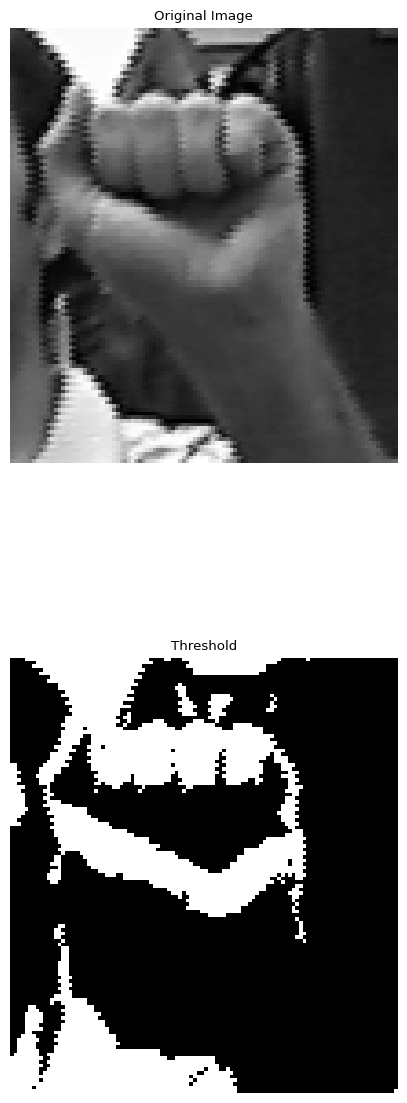

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path

image = cv2.imread('/content/dataset5/A/a/color_0_0002.png', cv2.IMREAD_GRAYSCALE)  # Directly read in grayscale

# Apply global thresholding
_, thresholded_image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(5,15))
plt.subplot(2,1,1)
plot_image(image, 'Original Image')
plt.subplot(2,1,2)
plot_image(thresholded_image, 'Threshold')

**Dataset for Thresholding Filter**

In [ ]:
def process_image(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Directly read in grayscale
    if image is None:
        print(f"Failed to load image at {image_path}")
        return

    # Apply global thresholding
    _, thresholded_image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)

    return thresholded_image

def create_directory(directory_path):
  if not os.path.exists(directory_path):
    os.makedirs(directory_path)

def process_dataset(input_directory, output_directory):

  # Path to the directory containing RGB images
  pathlist = Path(input_directory).rglob('*color*.png')
  print(pathlist)
  for path in pathlist:
    # Construct the path for the new directories
    new_dir = os.path.join(output_directory, path.parent.relative_to(input_directory))
    create_directory(new_dir)  # Create the directory if it does not exist

    # Process the image
    img = process_image(str(path))

    # Save the processed images in a new directory maintaining the structure

    cv2.imwrite(f"{new_dir}/{path.stem}.png", img) # even though edges is a binary images, cv2 will save it as rgb as its the default
    print(f"Processed and saved: {path.stem} in {new_dir}")

# Example usage
process_dataset('/content/selected_dataset5', '/content/selected_dataset5_thresholding')

Streaming output truncated to the last 5000 lines.
Processed and saved: C_color_6_0029 in /content/selected_dataset5_thresholding/G
Processed and saved: A_color_6_0041 in /content/selected_dataset5_thresholding/G
Processed and saved: B_color_6_0041 in /content/selected_dataset5_thresholding/G
Processed and saved: D_color_6_0019 in /content/selected_dataset5_thresholding/G
Processed and saved: A_color_6_0026 in /content/selected_dataset5_thresholding/G
Processed and saved: D_color_6_0033 in /content/selected_dataset5_thresholding/G
Processed and saved: B_color_6_0012 in /content/selected_dataset5_thresholding/G
Processed and saved: C_color_6_0011 in /content/selected_dataset5_thresholding/G
Processed and saved: C_color_6_0003 in /content/selected_dataset5_thresholding/G
Processed and saved: A_color_6_0031 in /content/selected_dataset5_thresholding/G
Processed and saved: E_color_6_0028 in /content/selected_dataset5_thresholding/G
Processed and saved: A_color_6_0014 in /content/selected_d

#**Median Filter**

**Applying Median filter Images**

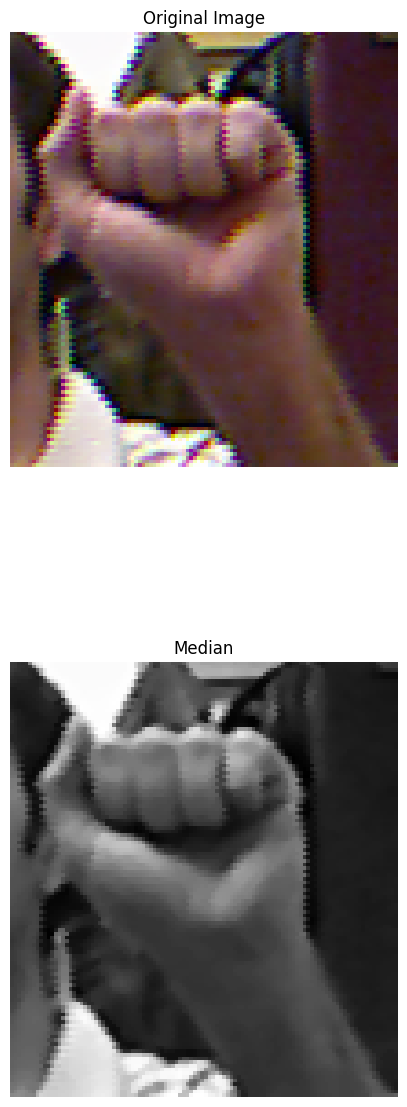

In [9]:
import cv2
import numpy as np
import os
from pathlib import Path
from skimage import io, color, filters
import random

img = io.imread('/content/dataset5/A/a/color_0_0002.png')
img_gray = color.rgb2gray(img)

# Apply median filter
img_median = filters.median(img_gray)
img_median_uint8 = (img_median * 255).astype(np.uint8)

plt.figure(figsize=(5,15))
plt.subplot(2,1,1)
plot_image(img, 'Original Image')
plt.subplot(2,1,2)
plot_image(img_median_uint8, 'Median')

**Dataset for Median Filter**

In [10]:
def process_image(image_path):
    img = io.imread(image_path)
    img_gray = color.rgb2gray(img)

    # Apply median filter
    img_median = filters.median(img_gray)
    img_median_uint8 = (img_median * 255).astype(np.uint8)

    return img_median_uint8

def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

def process_dataset(input_directory, output_directory):

  # Path to the directory containing RGB images
  pathlist = Path(input_directory).rglob('*color*.png')
  print(pathlist)
  for path in pathlist:
    # Construct the path for the new directories
    new_dir = os.path.join(output_directory, path.parent.relative_to(input_directory))
    create_directory(new_dir)  # Create the directory if it does not exist

    # Process the image
    edges = process_image(str(path))

    # Save the processed images in a new directory maintaining the structure

    cv2.imwrite(f"{new_dir}/{path.stem}.png", edges) # even though edges is a binary images, cv2 will save it as rgb as its the default
    print(f"Processed and saved: {path.stem} in {new_dir}")

# Example usage
process_dataset('/content/selected_dataset5', '/content/selected_dataset_median')

Streaming output truncated to the last 5000 lines.
Processed and saved: B_color_1_0035 in /content/selected_dataset_median/B
Processed and saved: A_color_1_0035 in /content/selected_dataset_median/B
Processed and saved: C_color_1_0023 in /content/selected_dataset_median/B
Processed and saved: B_color_1_0047 in /content/selected_dataset_median/B
Processed and saved: C_color_1_0013 in /content/selected_dataset_median/B
Processed and saved: E_color_1_0018 in /content/selected_dataset_median/B
Processed and saved: C_color_1_0026 in /content/selected_dataset_median/B
Processed and saved: E_color_1_0007 in /content/selected_dataset_median/B
Processed and saved: D_color_1_0029 in /content/selected_dataset_median/B
Processed and saved: D_color_1_0004 in /content/selected_dataset_median/B
Processed and saved: E_color_1_0050 in /content/selected_dataset_median/B
Processed and saved: E_color_1_0019 in /content/selected_dataset_median/B
Processed and saved: B_color_1_0034 in /content/selected_data

#**Data Training**

**Data transformation**

In [25]:
# this size is required for the pre-trained network

data_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()]) # will scale b/w 0 & 1 and convert to tensor

**Data training**

In [35]:
data_dir = '/content/selected_dataset_median'
#data_dir = '/content/selected_dataset_contr'
#data_dir = '/content/selected_dataset5_thresholding'
#data_dir = '/content/selected_dataset_canny'
# data_dir = '/content/selected_dataset5'

In [36]:
full_dataset = datasets.ImageFolder(data_dir, transform=data_transform)
full_dataset

Dataset ImageFolder
    Number of datapoints: 5750
    Root location: /content/selected_dataset_median
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [37]:
total_size = len(full_dataset)
train_size = int(total_size * 0.60)
validation_size = int(total_size * 0.20)
test_size = total_size - train_size - validation_size
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(full_dataset, (train_size, validation_size, test_size)) # 60 train and 20 for test and 20 for validation

**Create dataloaders for training the model in batches.**

In [38]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

image_datasets = {'train_dataset': train_dataset, 'validation_dataset': validation_dataset, 'test_dataset': test_dataset}
dataloaders = {'trainloader': train_loader, 'validationloader': validation_loader, 'testloader': test_loader}


In [39]:
class_to_idx = full_dataset.class_to_idx
class_to_idx

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'O': 13,
 'P': 14,
 'Q': 15,
 'R': 16,
 'S': 17,
 'T': 18,
 'U': 19,
 'V': 20,
 'W': 21,
 'X': 22}

In [40]:
idx_to_class = {value: key for key, value in class_to_idx.items()}
idx_to_class

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'K',
 10: 'L',
 11: 'M',
 12: 'N',
 13: 'O',
 14: 'P',
 15: 'Q',
 16: 'R',
 17: 'S',
 18: 'T',
 19: 'U',
 20: 'V',
 21: 'W',
 22: 'X'}

In [41]:
img, label = train_dataset[20][0], train_dataset[20][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {idx_to_class[label]}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.2235, 0.2196, 0.2196,  ..., 0.0863, 0.1490, 0.2039],
         [0.2235, 0.2235, 0.2235,  ..., 0.1255, 0.1882, 0.2314],
         [0.2235, 0.2235, 0.2235,  ..., 0.1725, 0.2314, 0.2627],
         ...,
         [0.0902, 0.0824, 0.0706,  ..., 0.0392, 0.0392, 0.0353],
         [0.0902, 0.0824, 0.0706,  ..., 0.0431, 0.0431, 0.0431],
         [0.0902, 0.0824, 0.0706,  ..., 0.0510, 0.0510, 0.0510]],

        [[0.2235, 0.2196, 0.2196,  ..., 0.0863, 0.1490, 0.2039],
         [0.2235, 0.2235, 0.2235,  ..., 0.1255, 0.1882, 0.2314],
         [0.2235, 0.2235, 0.2235,  ..., 0.1725, 0.2314, 0.2627],
         ...,
         [0.0902, 0.0824, 0.0706,  ..., 0.0392, 0.0392, 0.0353],
         [0.0902, 0.0824, 0.0706,  ..., 0.0431, 0.0431, 0.0431],
         [0.0902, 0.0824, 0.0706,  ..., 0.0510, 0.0510, 0.0510]],

        [[0.2235, 0.2196, 0.2196,  ..., 0.0863, 0.1490, 0.2039],
         [0.2235, 0.2235, 0.2235,  ..., 0.1255, 0.1882, 0.2314],
         [0.2235, 0.2235, 0.2235,  ..., 0.17

##**Data Testing**

In [42]:
# prepare an image to test with the model

import cv2
from google.colab.patches import cv2_imshow

def process_image(image):

  # Read an image
  image = cv2.imread(image, cv2.IMREAD_COLOR)

  # Resize the image to ensure consistent input size
  image = cv2.resize(image, (224, 224))

  # Convert BGR to RGB, since PyTorch expects RGB order
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Convert to a NumPy array and scale to [0, 1]
  np_image = image.astype(np.float32) / 255

  # Transpose to PyTorch's expected format: (channels, height, width)
  np_image = np_image.transpose(2, 0, 1)

  return np_image

<Axes: >

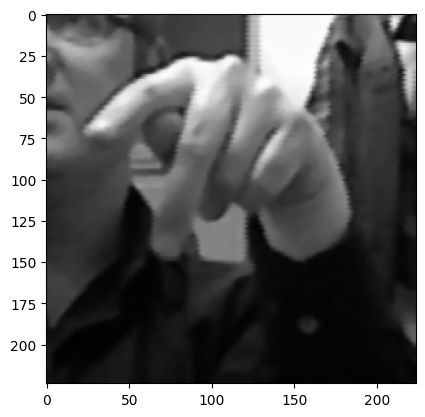

In [43]:
# to view an image tensor

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

imshow(img)

**This model is using a pre-trained model (EfficientNet)**

In [44]:
model = models.efficientnet_b0(pretrained=True)

for parameter in model.parameters(): # to not do backpropagation on previous layers, use them as they are (like feature selectors)
    parameter.requires_grad = False

# only changing the nn of the last layer/classifier so that it can fit to our data (was suitable for ImageNet before)
model.classifier = nn.Sequential(nn.Linear(1280, 256), # 1280 comes from the model's previous layer, 256 is a random value chosen for new layer nuerons (HP)
                                 nn.ReLU(), # activation
                                 nn.Dropout(0.2), # randomly drop some units in the nn to prevent overfitting
                                 nn.Linear(256, 24), # 256 from previous layer and 24 as output since we have 24 classes
                                 nn.LogSoftmax(dim=1)) # output

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 


In [45]:
device ='cuda' # to use the gpu later
learning_rate=0.003 # for our optimizer, too big value it won't converge, too low will be too slow, HP
epochs = 5 # train on the entire dataset 5 times, HP

model.to(device)
criterion = nn.NLLLoss() # loss function
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate) # optimizer for updating weights of model but only for last layer here


train_losses, validation_losses = [],[]
for epoch in range(epochs):
    training_loss = 0
    for images, labels in dataloaders['trainloader']:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # reset gradient to 0 for each batch
        logps = model(images) # output
        loss = criterion(logps, labels) # loss from loss function and output
        loss.backward() # calculate the gradient
        optimizer.step() # update the weights
        training_loss += loss.item()
    else: # after training on entire dataset
        validation_loss = 0
        accuracy = 0
        model.eval() # put in this mode for testing to not interfere with things done in training like dropout etc
        with torch.no_grad(): # turn off gradient calculation
            for images, labels in dataloaders['validationloader']:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                loss = criterion(logps, labels)
                validation_loss += loss.item()
                ps = torch.exp(logps) # ouput is logsoftmax so log(x), take exp to get x (the actual probability)
                top_p, top_class = ps.topk(1, dim=1) # find the highest probability n its class
                equals = top_class == labels.view(*top_class.shape) # compare with the actual label to see if they match, the label's shape is different to top_class so change shape before comparison else it will compare the top_class with each label of the batch
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item() # equals is a scalar in a tensor so get the value 0 or 1 use item and convert to float for adding because its byte before

        print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {training_loss/len(dataloaders['trainloader']):.3f}.. "
                  f"Validation loss: {validation_loss/len(dataloaders['validationloader']):.3f}.. "
                  f"Validation accuracy: {accuracy/len(dataloaders['validationloader']):.3f}")
        train_losses.append(training_loss/len(dataloaders['trainloader']))
        validation_losses.append(validation_loss/len(dataloaders['validationloader']))
        model.train()

Epoch 1/5.. Train loss: 1.618.. Validation loss: 0.668.. Validation accuracy: 0.811
Epoch 2/5.. Train loss: 0.589.. Validation loss: 0.334.. Validation accuracy: 0.904
Epoch 3/5.. Train loss: 0.352.. Validation loss: 0.260.. Validation accuracy: 0.925
Epoch 4/5.. Train loss: 0.270.. Validation loss: 0.217.. Validation accuracy: 0.932
Epoch 5/5.. Train loss: 0.200.. Validation loss: 0.180.. Validation accuracy: 0.942


##**Train and validation loss**

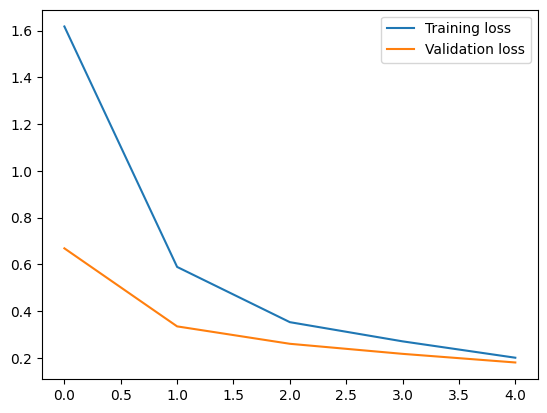

In [46]:
# Plot to compare the training and validation loss

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for images, labels in dataloaders['testloader']: # same as validation but on test set
        images, labels = images.to(device), labels.to(device)
        logps = model(images)
        loss = criterion(logps, labels)
        test_loss += loss.item()
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss on trained model: {test_loss/len(dataloaders['testloader']):.3f}.. "
      f"Test accuracy on trained model: {accuracy/len(dataloaders['testloader']):.3f}")

Test loss on trained model: 0.184.. Test accuracy on trained model: 0.949


#**Testing Predictions**

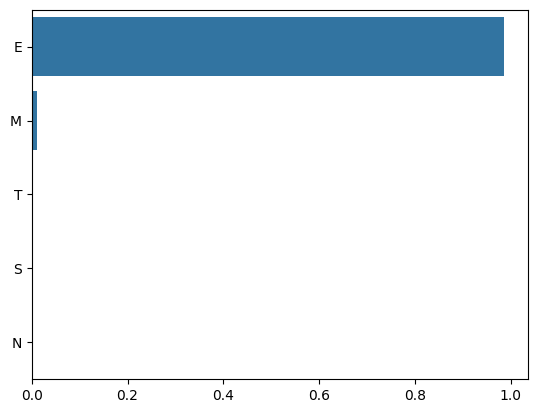

<Axes: >

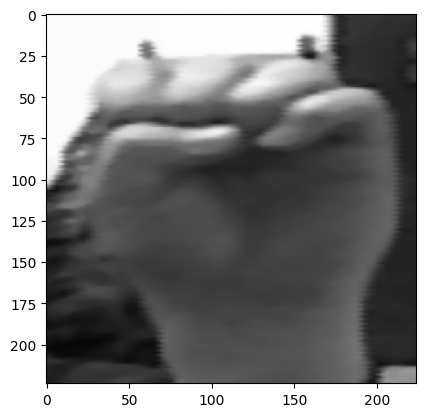

In [59]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    image = process_image(image_path) # gets it ready for model
    image = torch.from_numpy(image) # make tensor
    image = image.to('cuda')
    model.eval()
    with torch.no_grad():
      output = model(image.unsqueeze(0)) # add another dimension because we train in batches and now there is only 1 image
      ps = torch.exp(output)
      top_p, top_class = ps.topk(topk, dim=1)
    top_p = top_p.to('cpu')
    top_class = top_class.to('cpu')
    top_class = top_class.numpy().reshape(-1) #flattening

    new_list=[]
    for c in top_class:
      if c in idx_to_class.keys(): # c will be index, find the letters
        value = idx_to_class[c]
        new_list.append(value)

    return top_p.numpy().reshape(-1), new_list


probs, classes = predict('/content/selected_dataset_median/E/E_color_4_0050.png', model)

sorted_p_l = sorted(zip(probs, classes), reverse=True)  # sort the probabilities and letters together from high to low
probabilities, names = zip(*sorted_p_l) # seperate the tuples, one for probabilities and one for letters


base_color = sb.color_palette()[0]
sb.barplot(y=list(names), x=list(probabilities), color=base_color)
plt.show()


imshow(torch.from_numpy(process_image('/content/selected_dataset_median/E/E_color_4_0050.png')))

#**Using Webcam**

In [60]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [61]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes



def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)


  # save image
  cv2.imwrite(filename, img)

  return filename

**Try out yourself!**

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


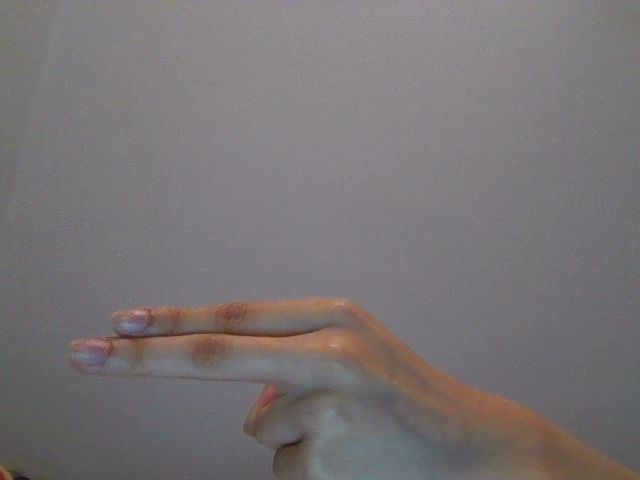

In [86]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

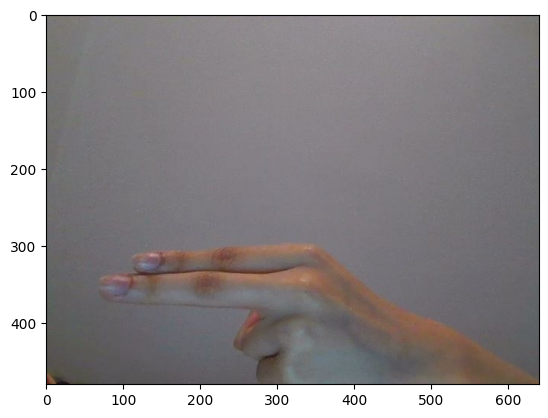

In [87]:
import cv2
import matplotlib.pyplot as plt
img2=cv2.imread("/content/photo.jpg")
plt.imshow(img2[:,:,::-1])
plt.show()

**Testing the Results**

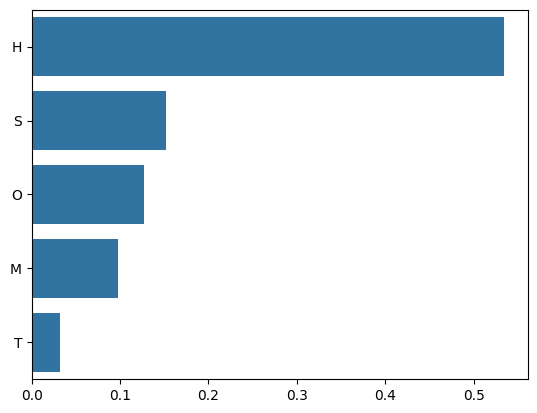

<Axes: >

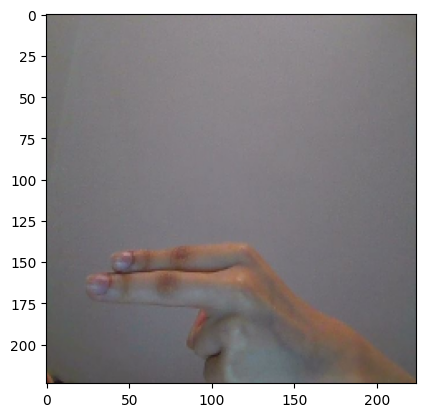

In [88]:
import cv2
import numpy as np
import os
from pathlib import Path
from skimage import io, color, exposure

def process_image_webcam(image_path):

    img = io.imread(image_path)
    img_gray = color.rgb2gray(img)

    # Apply median filter
    img_median = filters.median(img_gray)
    img_median_uint8 = (img_median * 255).astype(np.uint8)

process_image_webcam('/content/photo.jpg')


probs, classes = predict('/content/photo.jpg', model)

sorted_p_l = sorted(zip(probs, classes), reverse=True)  # sort the probabilities and letters together from high to low
probabilities, names = zip(*sorted_p_l) # seperate the tuples, one for probabilities and one for letters


base_color = sb.color_palette()[0]
sb.barplot(y=list(names), x=list(probabilities), color=base_color)
plt.show()


imshow(torch.from_numpy(process_image('/content/photo.jpg')))